In [1]:
import cv2
import focal_loss
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import tensorflow_addons as tfa
import warnings

from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K

from tensorflow.keras.applications import (EfficientNetB0, ResNet50,
                                           MobileNetV2, ResNet50V2,
                                           MobileNetV3Small, VGG16)


warnings.filterwarnings("ignore")

print(tf.__version__)
print(tf.keras.backend.image_data_format())

ModuleNotFoundError: No module named 'focal_loss'

In [2]:
MIXED_PRECISION = True

In [3]:
if MIXED_PRECISION:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070, compute capability 7.5
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
df_fold = pd.read_csv("folds.csv")
# FOLD 0 is private and kept for test

In [5]:
#Deeplabv3+

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes, backbone_name="resnet50", freeze_encoder=True):
    backbones = {
    'resnet50': {
        'model': ResNet50,
        'feature_1': 'conv4_block6_2_relu',
        'feature_2': 'conv2_block3_2_relu'
    },
    'resnet50v2': {
        'model': ResNet50V2,
        'feature_1':  'conv4_block5_1_relu',
        'feature_2': 'conv2_block2_2_relu'
    },
#     'mobilenetv2': {
#         'model': MobileNetV2,
#         'feature_1': 'out_relu',
#         'feature_2': 'block_3_expand_relu'
#     },
    'mobilenetv3small': {
        'model': MobileNetV3Small,
        'feature_1': 'multiply_17',
        'feature_2': 're_lu_3'
    },
    'efficientnetb0': {
        'model': EfficientNetB0,
        'feature_1': "top_activation",
        'feature_2': "block3a_expand_activation"
    },
#     'efficientnetv2b0': {
#         'model': EfficientNetV2B0,
#         'feature_1': "top_activation",
#         'feature_2': "block2b_expand_activation"
#     },
    'vgg16': {
        'model': VGG16,
        'feature_1': "block5_pool",
        'feature_2': "block3_conv3"
    },
    }
    
    model_input = keras.Input(shape=(image_size, image_size, 3))
    backbone = backbones[backbone_name]["model"](
        weights="imagenet", include_top=False, input_tensor=model_input
    )

    if freeze_encoder:
        for layer in backbone.layers:
            layer.trainable = False

    x = backbone.get_layer(backbones[backbone_name]["feature_1"]).output
    x = DilatedSpatialPyramidPooling(x)

    input_a = keras.layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = backbone.get_layer(backbones[backbone_name]["feature_2"]).output
    
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = keras.layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    
    if MIXED_PRECISION:
        model_output = keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(model_output)
    
    return keras.Model(inputs=model_input, outputs=model_output)


In [6]:
#UNET++ (XNET)
def handle_block_names(stage, cols):
    conv_name  = 'decoder_stage{}-{}_conv'.format(stage, cols)
    bn_name    = 'decoder_stage{}-{}_bn'.format(stage, cols)
    relu_name  = 'decoder_stage{}-{}_relu'.format(stage, cols)
    up_name    = 'decoder_stage{}-{}_upsample'.format(stage, cols)
    merge_name = 'merge_{}-{}'.format(stage, cols)
    return conv_name, bn_name, relu_name, up_name, merge_name


def ConvRelu(filters, kernel_size, use_batchnorm=False, conv_name='conv', bn_name='bn', relu_name='relu'):
    def layer(x):
        x = keras.layers.Conv2D(filters, kernel_size, padding="same", name=conv_name, use_bias=not(use_batchnorm))(x)
        if use_batchnorm:
            x = keras.layers.BatchNormalization(name=bn_name)(x)
        x = keras.layers.Activation('relu', name=relu_name)(x)
        return x
    return layer


def Upsample2D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2),
                     use_batchnorm=False, skip=None):
    def layer(input_tensor):
        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)
        x = keras.layers.UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)
        if (type(skip) != list and skip is not None) or (type(skip) == list and None not in skip):
            if type(skip) is list:
                x = keras.layers.Concatenate(name=merge_name)([x] + skip)
            else:
                x = keras.layers.Concatenate(name=merge_name)([x, skip])
        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)
        return x
    return layer


def Transpose2D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), use_batchnorm=False, skip=None):
    def layer(input_tensor):
        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)
        x = keras.layers.Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name, use_bias=not(use_batchnorm))(input_tensor)
        if use_batchnorm:
            x = keras.layers.BatchNormalization(name=bn_name+'1')(x)
        x = keras.layers.Activation('relu', name=relu_name+'1')(x)

        if (type(skip) != list and skip is not None) or (type(skip) == list and None not in skip):
            if type(skip) is list:
                merge_list = []
                merge_list.append(x)
                for l in skip:
                    merge_list.append(l)
                x = keras.layers.Concatenate(name=merge_name)(merge_list)
            else:
                x = keras.layers.Concatenate(name=merge_name)([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)
        return x
    return layer

def get_layer_number(model, layer_name):
    """
    Help find layer in Keras model by name
    Args:
        model: Keras `Model`
        layer_name: str, name of layer
    Returns:
        index of layer
    Raises:
        ValueError: if model does not contains layer with such name
    """
    for i, l in enumerate(model.layers):
        if l.name == layer_name:
            return i
    raise ValueError('No layer with name {} in  model {}.'.format(layer_name, model.name))
    
def to_tuple(x):
    if isinstance(x, tuple):
        if len(x) == 2:
            return x
    elif np.isscalar(x):
        return (x, x)
    raise ValueError('Value should be tuple of length 2 or int value, got "{}"'.format(x))


def build_xnet(backbone, classes, skip_connection_layers,
               decoder_filters=(256,128,64,32,16),
               upsample_rates=(2,2,2,2,2),
               n_upsample_blocks=5,
               block_type='upsampling',
               activation='sigmoid',
               use_batchnorm=True):

    input = backbone.input
    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    if len(skip_connection_layers) > n_upsample_blocks:
        downsampling_layers = skip_connection_layers[int(len(skip_connection_layers)/2):]
        skip_connection_layers = skip_connection_layers[:int(len(skip_connection_layers)/2)]
    else:
        downsampling_layers = skip_connection_layers

    # convert layer names to indices
    skip_connection_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l 
                            for l in skip_connection_layers])
    skip_layers_list    = [backbone.layers[skip_connection_idx[i]].output for i in range(len(skip_connection_idx))]
    
    downsampling_idx  = ([get_layer_number(backbone, l) if isinstance(l, str) else l 
                          for l in downsampling_layers])
    downsampling_list = [backbone.layers[downsampling_idx[i]].output for i in range(len(downsampling_idx))]
    downterm = [None] * (n_upsample_blocks+1)
    
    for i in range(len(downsampling_idx)):        
        downterm[n_upsample_blocks-i-1] = downsampling_list[i]
            
    downterm[-1] = backbone.output
    interm = [None] * (n_upsample_blocks+1) * (n_upsample_blocks+1)
    for i in range(len(skip_connection_idx)):
        interm[-i*(n_upsample_blocks+1)+(n_upsample_blocks+1)*(n_upsample_blocks-1)] = skip_layers_list[i]
        
    interm[(n_upsample_blocks+1)*n_upsample_blocks] = backbone.output
    for j in range(n_upsample_blocks):
        for i in range(n_upsample_blocks-j):
            upsample_rate = to_tuple(upsample_rates[i])
           
            if i == 0 and j < n_upsample_blocks-1 and len(skip_connection_layers) < n_upsample_blocks:
                interm[(n_upsample_blocks+1)*i+j+1] = None
            elif j == 0:
                if downterm[i+1] is not None:
                    interm[(n_upsample_blocks+1)*i+j+1] = up_block(decoder_filters[n_upsample_blocks-i-2], 
                                      i+1, j+1, upsample_rate=upsample_rate,
                                      skip=interm[(n_upsample_blocks+1)*i+j], 
                                      use_batchnorm=use_batchnorm)(downterm[i+1])
                else:
                    interm[(n_upsample_blocks+1)*i+j+1] = None
            else:
                interm[(n_upsample_blocks+1)*i+j+1] = up_block(decoder_filters[n_upsample_blocks-i-2], 
                                  i+1, j+1, upsample_rate=upsample_rate,
                                  skip=interm[(n_upsample_blocks+1)*i : (n_upsample_blocks+1)*i+j+1], 
                                  use_batchnorm=use_batchnorm)(interm[(n_upsample_blocks+1)*(i+1)+j])
  
    x = keras.layers.Conv2D(classes, (3,3), padding='same', name='final_conv')(interm[n_upsample_blocks])
    x = keras.layers.Activation(activation, name=activation)(x)
    
    if MIXED_PRECISION:
        x = keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(x)
        
    model = keras.Model(input, x)
    return model

backbones = {
    "efficientnetb0": EfficientNetB0,
#     "efficientnetb1": EfficientNetB1,
#     "efficientnetb2": EfficientNetB2,
#     "efficientnetb3": EfficientNetB3,
#     "efficientnetb4": EfficientNetB4,
#     "efficientnetb5": EfficientNetB5,
#     "efficientnetb6": EfficientNetB6,
#     "efficientnetb7": EfficientNetB7,
#     "efficientnetv2b0": EfficientNetV2B0,
    "resnet50": ResNet50,
    "resnet50v2": ResNet50V2,
    "mobilenetv3small": MobileNetV3Small,
    "vgg16": VGG16,
}

def get_backbone(name, *args, **kwargs):
    return backbones[name](*args, **kwargs)

def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return

DEFAULT_SKIP_CONNECTIONS = {
    'efficientnetb0': ('block6a_expand_activation', 'block4a_expand_activation',
                       'block3a_expand_activation', 'block2a_expand_activation'),
#     'efficientnetb1': ('block6a_expand_activation', 'block4a_expand_activation',
#                        'block3a_expand_activation', 'block2a_expand_activation'),
#     'efficientnetb2': ('block6a_expand_activation', 'block4a_expand_activation',
#                        'block3a_expand_activation', 'block2a_expand_activation'),
#     'efficientnetb3': ('block6a_expand_activation', 'block4a_expand_activation',
#                        'block3a_expand_activation', 'block2a_expand_activation'),
#     'efficientnetb4': ('block6a_expand_activation', 'block4a_expand_activation',
#                        'block3a_expand_activation', 'block2a_expand_activation'),
#     'efficientnetb5': ('block6a_expand_activation', 'block4a_expand_activation',
#                        'block3a_expand_activation', 'block2a_expand_activation'),
#     'efficientnetb6': ('block6a_expand_activation', 'block4a_expand_activation',
#                        'block3a_expand_activation', 'block2a_expand_activation'),
#     'efficientnetb7': ('block6a_expand_activation', 'block4a_expand_activation',
#                        'block3a_expand_activation', 'block2a_expand_activation'),
#     'efficientnetv2b0': ('block5b_expand_activation', 'block4a_expand_activation',
#                        'block2b_expand_activation', 'block1a_project_activation'),
    'resnet50': ("conv4_block6_out", "conv3_block4_out",
                 "conv2_block3_out", "conv1_relu" ),
    'resnet50v2' : ("conv4_block6_preact_relu", "conv3_block4_preact_relu", 
                    "conv2_block3_preact_relu", "conv1_conv"),
    'mobilenetv3small' : ("multiply_11", "multiply_1",
                          "re_lu_3", "multiply"),
    'vgg16': ( "block5_conv3", "block4_conv3",
              "block3_conv3", "block2_conv2"),             
}


def Xnet(backbone_name='efficientnetb0',
         input_shape=(None, None, 3),
         input_tensor=None,
         encoder_weights='imagenet',
         freeze_encoder=False,
         skip_connections='default',
         decoder_block_type='upsampling',
         decoder_filters=(256,128,64,32,16),
         decoder_use_batchnorm=True,
         n_upsample_blocks=5,
         upsample_rates=(2,2,2,2,2),
         classes=1,
         activation='sigmoid'):
    backbone = get_backbone(backbone_name,
                            input_shape=input_shape,
                            input_tensor=input_tensor,
                            weights=encoder_weights,
                            include_top=False)

    if skip_connections == 'default':
        skip_connections = DEFAULT_SKIP_CONNECTIONS[backbone_name]
  
    model = build_xnet(backbone,
                       classes,
                       skip_connections,
                       decoder_filters=decoder_filters,
                       block_type=decoder_block_type,
                       activation=activation,
                       n_upsample_blocks=n_upsample_blocks,
                       upsample_rates=upsample_rates,
                       use_batchnorm=decoder_use_batchnorm)

    # lock encoder weights for fine-tuning
    if freeze_encoder:
        freeze_model(backbone)

    return model

In [16]:
#classic unet

def UNET(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    #outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    outputs = keras.layers.Conv2D(num_classes, 3, activation=None, padding="same")(x)
    if MIXED_PRECISION:
        outputs = keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(outputs)
    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [17]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.name = 'dice_loss'
        self.smooth = smooth

    def call(self, y_true, y_pred, sample_weights=None):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        y_pred = tf.nn.softmax(y_pred, axis=-1)

#         numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2]) + self.smooth
#         denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) + self.smooth

        y_true_f = tf.cast(tf.reshape(y_true, [-1, self.num_classes]), tf.float32)
        y_pred_f = tf.reshape(y_pred, [-1, self.num_classes])
        numerator = 2.0 * tf.reduce_sum(y_true_f * y_pred_f, axis=0) + self.smooth
        denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0) + self.smooth

        dice_loss = 1 - tf.reduce_mean(numerator / denominator)

        return dice_loss

class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, loss1, loss2):
        super(CombinedLoss, self).__init__()
        self.loss1 = loss1
        self.loss2 = loss2

    def call(self, y_true, y_pred, sample_weights=None):
        loss1_value = self.loss1(y_true, y_pred, sample_weights)
        loss2_value = self.loss2(y_true, y_pred, sample_weights)
        combined_loss = loss1_value + loss2_value
        return combined_loss

In [18]:
IMAGE_SIZE = 448
BATCH_SIZE = 2
NUM_CLASSES = len(np.unique(np.concatenate([tf.image.decode_png(tf.io.read_file("mask/"+f), channels=1).numpy().flatten() for f in os.listdir("mask")])))

In [19]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE, method="nearest")
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

@tf.function
def augment(image, mask):

    choice = tf.random.uniform(())
    if choice > 0.1:
        angle_range = math.radians(5)
        angle = tf.random.uniform(shape=[], minval=-angle_range, maxval=angle_range, dtype=tf.float32)
        image = tfa.image.rotate(image, angle, interpolation='bilinear')
        mask = tfa.image.rotate(mask, angle, interpolation='nearest')

    choice = tf.random.uniform(())
    if choice > 0.25:
        a = tf.random.uniform(shape=[], minval=0.7, maxval=1.0)
        image = tf.image.central_crop(image, a)
        mask = tf.image.central_crop(mask, a)
        image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        mask = tf.image.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), method="nearest")
    else:
        image_shape = tf.shape(image)
        mask_shape = tf.shape(mask)
        crop_size = tf.random.uniform(shape=[], minval=0.7, maxval=1.0)
        crop_height = tf.cast(tf.cast(image_shape[0], tf.float32) * crop_size, tf.int32)
        crop_width = tf.cast(tf.cast(image_shape[1], tf.float32) * crop_size, tf.int32)
        offset_height = tf.random.uniform(shape=[], maxval=image_shape[0] - crop_height + 1, dtype=tf.int32)
        offset_width = tf.random.uniform(shape=[], maxval=image_shape[1] - crop_width + 1, dtype=tf.int32)
        image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, crop_height, crop_width)
        mask = tf.image.crop_to_bounding_box(mask, offset_height, offset_width, crop_height, crop_width)
        image = tf.image.resize(image, image_shape[:2])
        mask = tf.image.resize(mask, mask_shape[:2], method="nearest")

    choice = tf.random.uniform(())
    if choice > 0.8:
        image = tf.image.random_brightness(image, max_delta=8)
        image = tf.clip_by_value(image, 0.0, 255.0)

        image = tf.image.random_contrast(image, lower=0.95, upper=1.3)
        image = tf.clip_by_value(image, 0.0, 255.0)

    elif choice > 0.7:
        image = tfa.image.equalize(image)
        image = tf.clip_by_value(image, 0.0, 255.0)

    elif choice > 0.5:
        image_gamma = tf.image.adjust_gamma(image, tf.random.uniform(shape=[], minval=0.6, maxval=1.4) )
        image_gamma = tf.clip_by_value(image_gamma, 0.0, 255.0)

    choice = tf.random.uniform(())
    if choice > 0.75:
        image = tfa.image.gaussian_filter2d(image)
        image = tf.clip_by_value(image, 0.0, 255.0)
    elif choice > 0.5:
        image = tfa.image.median_filter2d(image)
        image = tf.clip_by_value(image, 0.0, 255.0)
    elif choice > 0.25:
        image = tfa.image.mean_filter2d(image)
        image = tf.clip_by_value(image, 0.0, 255.0)

    mask = tf.cast(mask, tf.uint8)
    return image, mask

In [20]:
# resnet50, resnet50v2, mobilenetv3small, efficientnetb0, vgg16
MYBACKBONENAME = "resnet50"
# xnet, deeplabv3plus, unet
MODELNAME = "xnet"
# fromscratch, frozen, finetuning
TRAINING_MODE = "fromscratch"
if TRAINING_MODE == "frozen":
    FREEZING = True
    n_epochs = 30
elif TRAINING_MODE == "fromscratch":
    FREEZING = False
    n_epochs = 50
elif TRAINING_MODE == "finetuning":
    FREEZING = True
    n_epochs = 10
# orig, clahe
PREPROCESSING = "orig"
# wfldl, wfl, dl, wcel, wceldl
LOSS = "wceldl"


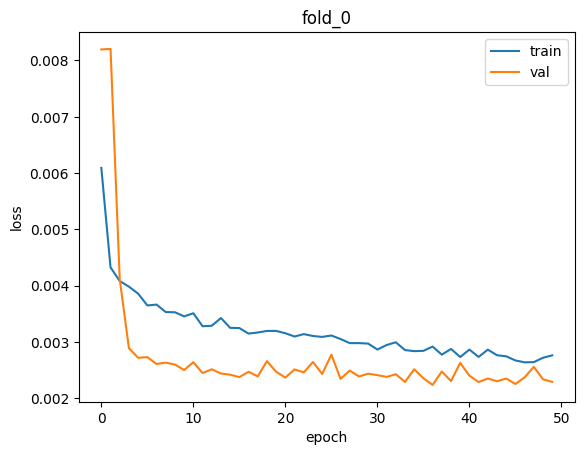

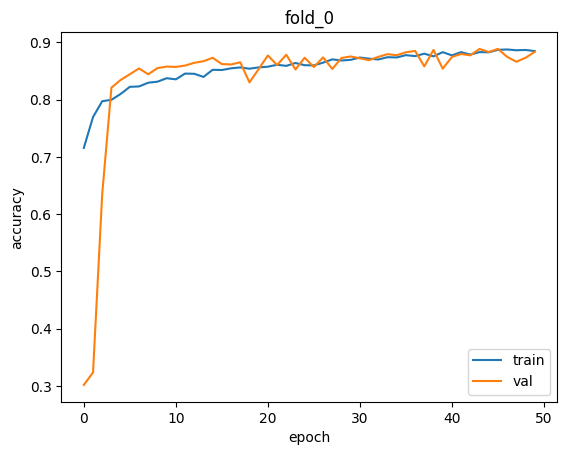

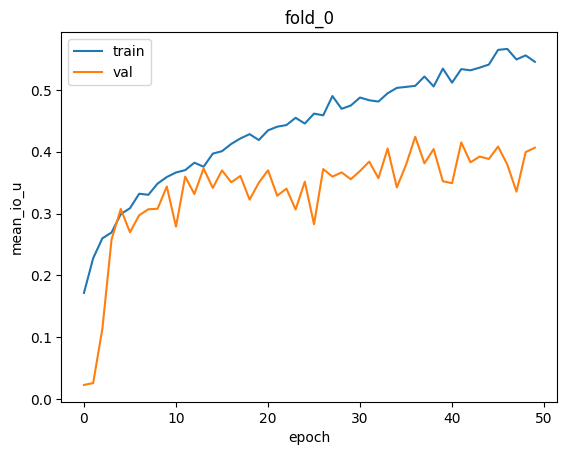

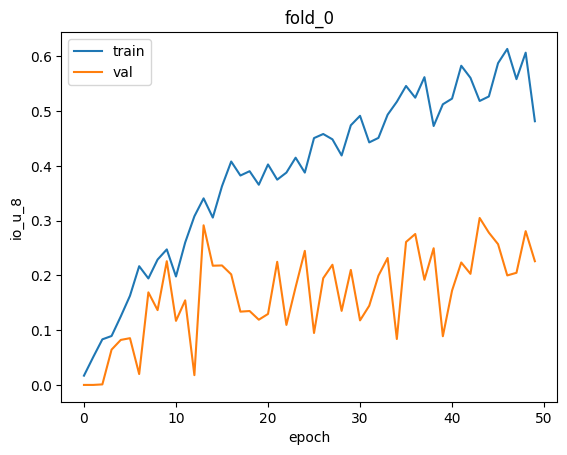

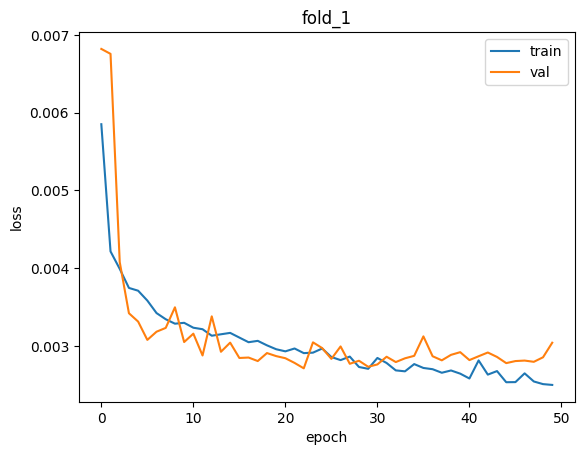

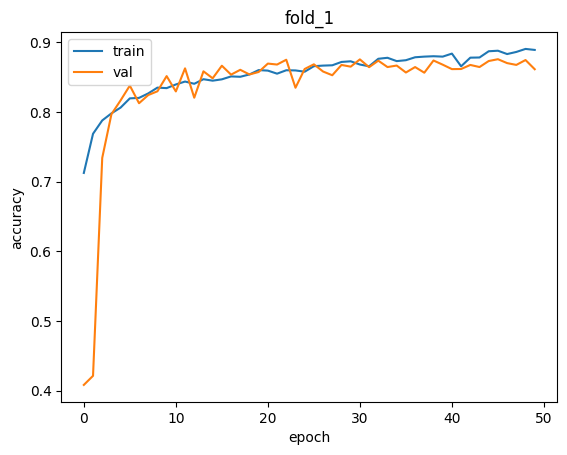

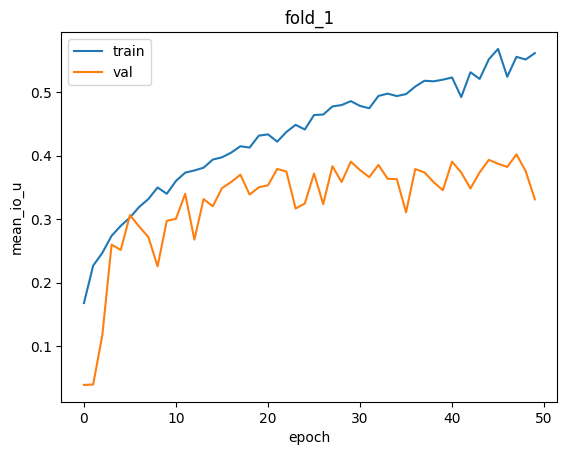

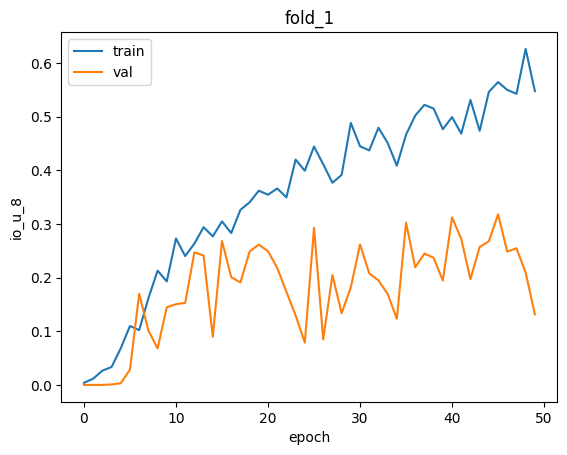

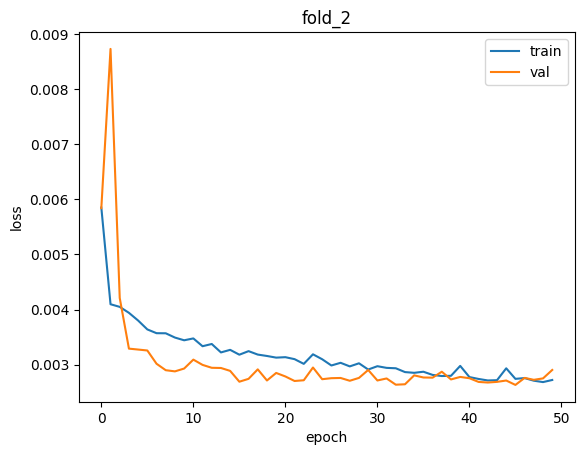

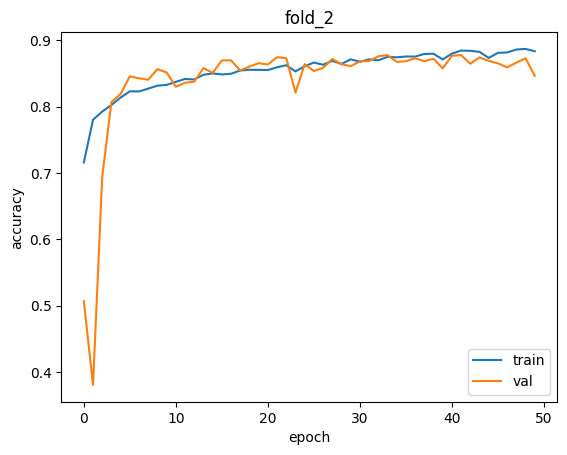

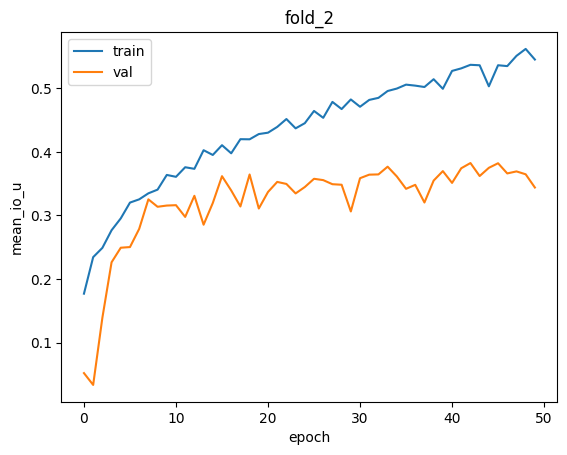

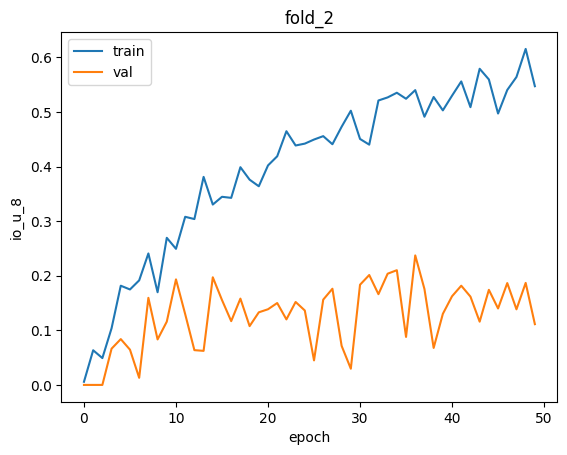

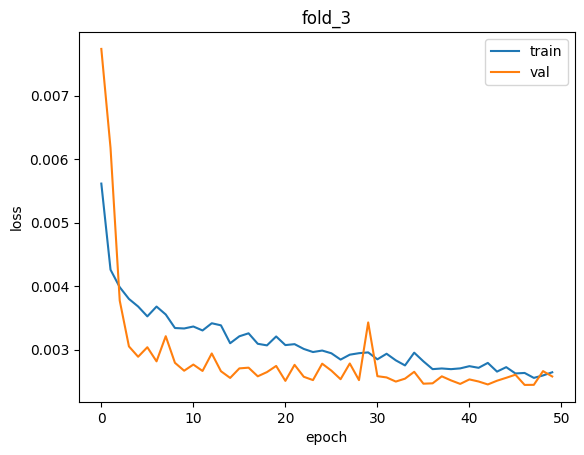

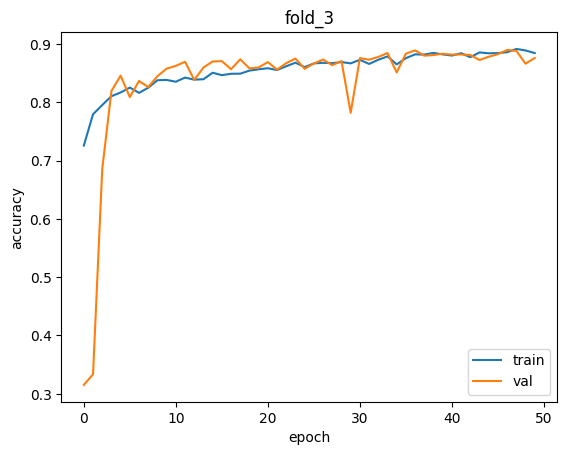

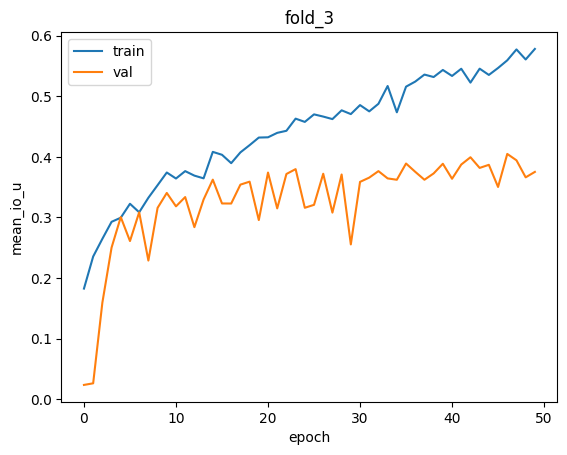

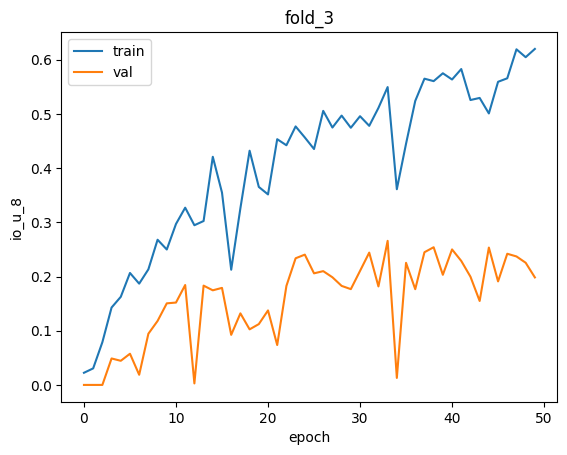

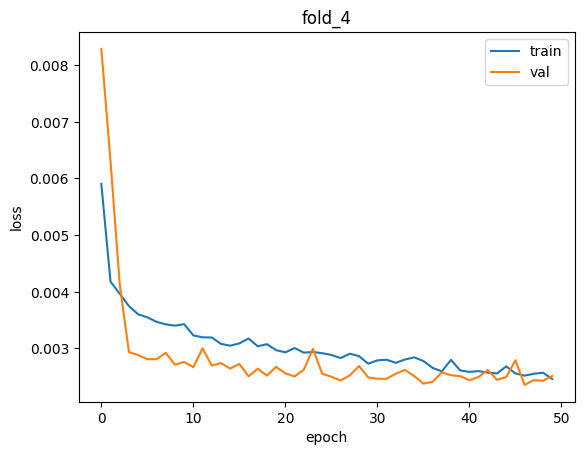

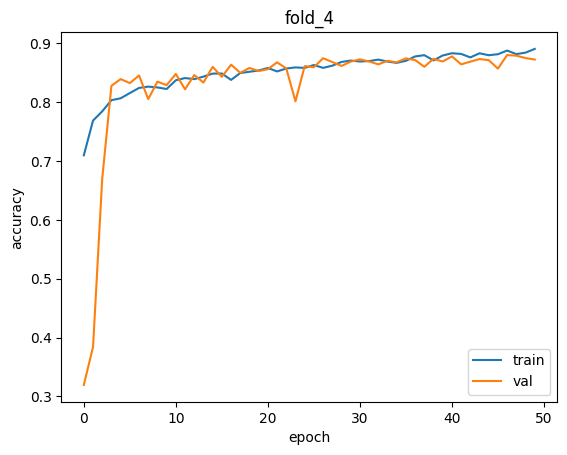

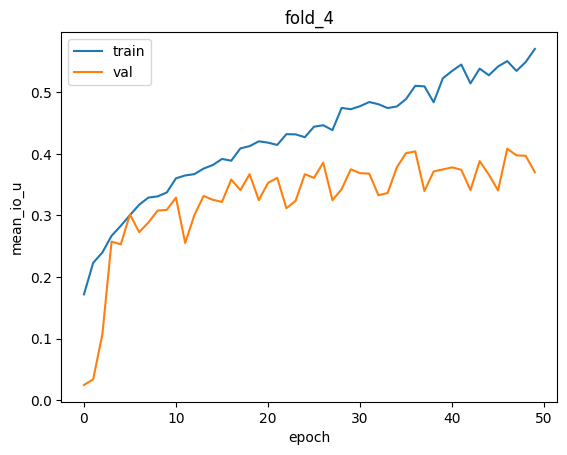

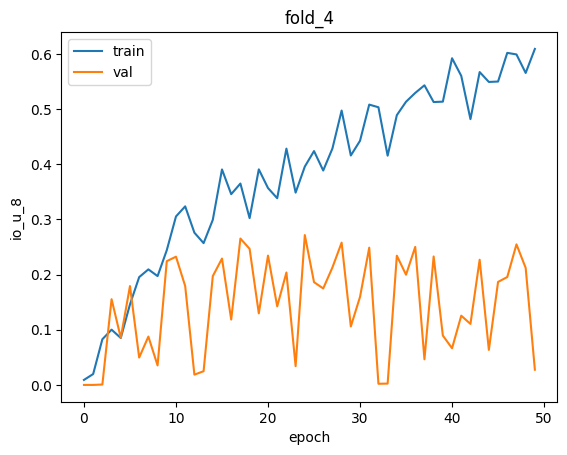

In [21]:

history_filename = f"{MODELNAME}-{LOSS}-{MYBACKBONENAME}-{TRAINING_MODE}-aug-{PREPROCESSING}-{IMAGE_SIZE}"

if MYBACKBONENAME == "resnet50":
    def specific_preprocess(image, mask):
        image = tf.keras.applications.resnet.preprocess_input(image)
        return image, mask
elif MYBACKBONENAME == "resnet50v2":
    def specific_preprocess(image, mask):
        image = tf.keras.applications.resnet_v2.preprocess_input(image)
        return image, mask
elif MYBACKBONENAME == "vgg16":
    def specific_preprocess(image, mask):
        image = tf.keras.applications.vgg16.preprocess_input(image)
        return image, mask
else:
    def specific_preprocess(image, mask):
        return image, mask
    
history = {}
evaluations = {}
for currentfold in range(5):
   
    train_files = (df_fold[~df_fold["classification_fold"].isin([currentfold, 5])]["file"]).values
    val_files = (df_fold[df_fold["classification_fold"] == currentfold]["file"]).values
    
    train_masks = ["mask/"+f for f in train_files]
    train_images = [f"png_{PREPROCESSING}/{f}" for f in train_files]
    val_masks = ["mask/"+f for f in val_files]
    val_images = [f"png_{PREPROCESSING}/{f}" for f in val_files]
    
    w = pd.Series(np.concatenate([tf.image.decode_png(tf.io.read_file("mask/"+f), channels=1).numpy().flatten() for f in train_files])).value_counts()
    w = w.sort_index()
    class_weights = w.sum() / (w.values * len(w))
    
    def add_sample_weights(image, label, weights=class_weights):
        class_weights = tf.constant(weights)
        class_weights = class_weights/tf.reduce_sum(class_weights)
        sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
        return image, label, sample_weights
    
    NUM_TRAIN_IMAGES = len(train_files)
    NUM_VAL_IMAGES = len(val_files)
    STEPS_PER_EPOCH = NUM_TRAIN_IMAGES // BATCH_SIZE

    train_dataset = (tf.data.Dataset
        .from_tensor_slices((train_images, train_masks))
        .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(len(train_images))
        .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        .repeat()
        .batch(BATCH_SIZE, drop_remainder=True)
        .map(specific_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .map(add_sample_weights)
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    val_dataset = (tf.data.Dataset
        .from_tensor_slices((val_images, val_masks))
        .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE, drop_remainder=True)
        .map(specific_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .map(add_sample_weights)
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    tf.keras.backend.clear_session()
    
    if MODELNAME == "deeplabv3plus":
        model = DeeplabV3Plus(
            image_size=IMAGE_SIZE,
            num_classes=NUM_CLASSES,
            backbone_name=MYBACKBONENAME,
            freeze_encoder=FREEZING)
    elif MODELNAME == "xnet":    
        model = Xnet(
            backbone_name=MYBACKBONENAME, 
            encoder_weights='imagenet',
            decoder_block_type='upsampling',
            decoder_filters=(256,128,64,32,16),
            decoder_use_batchnorm=True,
            n_upsample_blocks=5,
            upsample_rates=(2,2,2,2,2),
            classes=NUM_CLASSES,
            activation=None,
            freeze_encoder=FREEZING)
    elif MODELNAME == "unet":
        model = UNET((IMAGE_SIZE, IMAGE_SIZE), NUM_CLASSES)
    else:
        assert(False)
    
    loss1 = focal_loss.SparseCategoricalFocalLoss(gamma=1., from_logits=True)
    loss2 = DiceLoss(NUM_CLASSES)
    loss3 = keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=None)
    
    if LOSS == "wfldl":
        loss = CombinedLoss(loss1, loss2)
    elif LOSS == "dl":
        loss = loss2
    elif LOSS == "wfl":
        loss = loss1
    elif LOSS == "wcel":
        loss = loss3
    elif LOSS == "wceldl":
        loss = CombinedLoss(loss1, loss3)
    
    model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=loss,
    weighted_metrics=[],
    metrics = [
        "accuracy",
        tf.keras.metrics.MeanIoU(sparse_y_pred=False, sparse_y_true=True, num_classes=NUM_CLASSES, name='mean_io_u'),
        tf.keras.metrics.IoU(sparse_y_pred=False, sparse_y_true=True, target_class_ids=[8], name='io_u_8', num_classes=NUM_CLASSES),
    ],
    )

#     callbacks = [
#     keras.callbacks.ModelCheckpoint('./best_model_'+str(currentfold)+'.h5', save_weights_only=True, save_best_only=True, mode='min'),   
#     ]

    history[currentfold] = model.fit(train_dataset,
                                     steps_per_epoch = STEPS_PER_EPOCH,
                                     validation_data=val_dataset,
                                     epochs=n_epochs,
                                     #callbacks=callbacks,
                                     verbose=0,
                                    )
    
    if TRAINING_MODE == "finetuning":
        
        for layer in model.layers:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True
        
        model.compile(
            optimizer=keras.optimizers.Adam(1e-4),
            loss=loss,
            weighted_metrics=[],
            metrics = [
                "accuracy",
                tf.keras.metrics.MeanIoU(sparse_y_pred=False, sparse_y_true=True, num_classes=NUM_CLASSES, name='mean_io_u'),
                tf.keras.metrics.IoU(sparse_y_pred=False, sparse_y_true=True, target_class_ids=[8], name='io_u_8', num_classes=NUM_CLASSES),
            ],
            )
        
        history[currentfold] = model.fit(train_dataset,
                                     steps_per_epoch = STEPS_PER_EPOCH,
                                     validation_data=val_dataset,
                                     epochs=15,
                                     #callbacks=callbacks,
                                     verbose=0,
                                    )
   
    h = history[currentfold]
    
    pd.DataFrame(h.history).to_csv("results/"+history_filename+"_"+str(currentfold)+".csv", index=False)
    
    keys = list(h.history.keys())
    for idx in range(len(keys) // 2):
        plt.title("fold_"+str(currentfold))
        plt.plot(h.history[keys[idx]], label="train")
        plt.ylabel(keys[idx])
        plt.plot(h.history[keys[idx+len(keys) // 2]], label="val")
        plt.legend()
        plt.xlabel("epoch")
        plt.show()

In [19]:
n_epochs = 47
train_files = (df_fold[~df_fold["classification_fold"].isin([5])]["file"]).values

train_masks = ["mask/"+f for f in train_files]
train_images = [f"png_{PREPROCESSING}/{f}" for f in train_files]

w = pd.Series(np.concatenate([tf.image.decode_png(tf.io.read_file("mask/"+f), channels=1).numpy().flatten() for f in train_files])).value_counts()
w = w.sort_index()
class_weights = w.sum() / (w.values * len(w))

def add_sample_weights(image, label, weights=class_weights):
    class_weights = tf.constant(weights)
    class_weights = class_weights/tf.reduce_sum(class_weights)
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

NUM_TRAIN_IMAGES = len(train_files)

STEPS_PER_EPOCH = NUM_TRAIN_IMAGES // BATCH_SIZE

train_dataset = (tf.data.Dataset
    .from_tensor_slices((train_images, train_masks))
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(len(train_images))
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .repeat()
    .batch(BATCH_SIZE, drop_remainder=True)
    .map(specific_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .map(add_sample_weights)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

tf.keras.backend.clear_session()

if MODELNAME == "deeplabv3plus":
    model = DeeplabV3Plus(
        image_size=IMAGE_SIZE,
        num_classes=NUM_CLASSES,
        backbone_name=MYBACKBONENAME,
        freeze_encoder=FREEZING)
elif MODELNAME == "xnet":    
    model = Xnet(
        backbone_name=MYBACKBONENAME, 
        encoder_weights='imagenet',
        decoder_block_type='upsampling',
        decoder_filters=(256,128,64,32,16),
        decoder_use_batchnorm=True,
        n_upsample_blocks=5,
        upsample_rates=(2,2,2,2,2),
        classes=NUM_CLASSES,
        activation=None,
        freeze_encoder=FREEZING)
else:
    assert(False)


loss1 = focal_loss.SparseCategoricalFocalLoss(gamma=1., from_logits=True)
loss2 = DiceLoss(NUM_CLASSES)
loss3 = keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=None)

if LOSS == "wfldl":
    loss = CombinedLoss(loss1, loss2)
elif LOSS == "dl":
    loss = loss2
elif LOSS == "wfl":
    loss = loss1
elif LOSS == "wcel":
    loss = loss3

model.compile(
optimizer=keras.optimizers.Adam(3e-4),
loss=loss,
weighted_metrics=[],
metrics = [
    "accuracy",
    tf.keras.metrics.MeanIoU(sparse_y_pred=False, sparse_y_true=True, num_classes=NUM_CLASSES, name='mean_io_u'),
    tf.keras.metrics.IoU(sparse_y_pred=False, sparse_y_true=True, target_class_ids=[8], name='io_u_8', num_classes=NUM_CLASSES),
],
)

#     callbacks = [
#     keras.callbacks.ModelCheckpoint('./best_model_'+str(currentfold)+'.h5', save_weights_only=True, save_best_only=True, mode='min'),   
#     ]

history = model.fit(train_dataset,
                                 steps_per_epoch = STEPS_PER_EPOCH,
                                 validation_data=None,
                                 epochs=n_epochs,
                                 #callbacks=callbacks,
                                 verbose=1,
                                )




Epoch 1/47
227/227 [==============================] - 34s 114ms/step - loss: 0.0043 - accuracy: 0.8238 - mean_io_u: 0.2367 - io_u_8: 0.0057
Epoch 2/47
227/227 [==============================] - 27s 119ms/step - loss: 0.0034 - accuracy: 0.8696 - mean_io_u: 0.3135 - io_u_8: 0.0136
Epoch 3/47
227/227 [==============================] - 26s 115ms/step - loss: 0.0032 - accuracy: 0.8738 - mean_io_u: 0.3593 - io_u_8: 0.1532
Epoch 4/47
227/227 [==============================] - 26s 115ms/step - loss: 0.0030 - accuracy: 0.8805 - mean_io_u: 0.4028 - io_u_8: 0.2598
Epoch 5/47
227/227 [==============================] - 26s 114ms/step - loss: 0.0029 - accuracy: 0.8860 - mean_io_u: 0.4271 - io_u_8: 0.2880
Epoch 6/47
227/227 [==============================] - 26s 113ms/step - loss: 0.0029 - accuracy: 0.8888 - mean_io_u: 0.4481 - io_u_8: 0.3452
Epoch 7/47
227/227 [==============================] - 28s 123ms/step - loss: 0.0028 - accuracy: 0.8911 - mean_io_u: 0.4626 - io_u_8: 0.3869
Epoch 8/47
227/227 [

In [21]:
model.save("best_model")